# Classifying Stars Using a Neural Network

## Introduction

The dataset we'll be looking at contains information on stars. The goal is to classify the type of stars based on the other features provided. The features in the dataset include:

- Temperature
- Luminosity
- Radius
- Absolute magnitude
- Star type
- Star color 
- Spectral class

The categories of stars are as follows:

- Brown Dwarf = 0
- Red Dwarf = 1
- White Dwarf = 2
- Main Sequence = 3
- Supergiant = 4
- Hypergiant = 5

## Preparing the Data

In [1]:
import pandas as pd

stars = pd.read_csv('Data Sets/Stars.csv')

In [2]:
stars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
Temperature (K)           240 non-null int64
Luminosity(L/Lo)          240 non-null float64
Radius(R/Ro)              240 non-null float64
Absolute magnitude(Mv)    240 non-null float64
Star type                 240 non-null int64
Star color                240 non-null object
Spectral Class            240 non-null object
dtypes: float64(3), int64(2), object(2)
memory usage: 13.2+ KB


Luckily there are no missing data points; however, we do need to encode the categorical features. Let's take a look at the first five observations to get an idea of what we are working with.

In [3]:
stars.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Red,M
1,3042,0.000500,0.1542,16.60,0,Red,M
2,2600,0.000300,0.1020,18.70,0,Red,M
3,2800,0.000200,0.1600,16.65,0,Red,M
4,1939,0.000138,0.1030,20.06,0,Red,M


We'll need to encode both the star color and spectral class. Star type will also have to be encoded, but we will wait until we assign star type as the target.

In [4]:
stars = pd.get_dummies(stars, columns=['Star color', 'Spectral Class'])

In [5]:
stars.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color_Blue,Star color_Blue,Star color_Blue White,Star color_Blue white,Star color_Blue white,...,Star color_white,Star color_yellow-white,Star color_yellowish,Spectral Class_A,Spectral Class_B,Spectral Class_F,Spectral Class_G,Spectral Class_K,Spectral Class_M,Spectral Class_O
0,3068,0.002400,0.1700,16.12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,3042,0.000500,0.1542,16.60,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2600,0.000300,0.1020,18.70,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2800,0.000200,0.1600,16.65,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1939,0.000138,0.1030,20.06,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


This more than doubles our dimensions. Luckily we didn't start with that many features.

### Splitting Data into Train and Test Sets

Let's go ahead and split the data into train and test sets. We will also encode the star type now that it has been dropped and made into the target dataset.

In [6]:
from sklearn.model_selection import train_test_split

predictors = stars.drop('Star type', axis = 1)
target = stars['Star type']
target = pd.get_dummies(target)
X_train, X_test, Y_train, Y_test = train_test_split(predictors, target, 
                                                    test_size = 0.20, 
                                                    random_state = 1)

### Pre-processing

Next we will normalize the data using the standard scaler in sklearn. The data will have a mean of zero and a standard deviation of one.

In [7]:
from sklearn import preprocessing

std_scaler = preprocessing.StandardScaler().fit(X_train)

def scaler(X):
    x_norm_arr = std_scaler.fit_transform(X)
    return pd.DataFrame(x_norm_arr, columns = X.columns, index = X.index)

X_train = scaler(X_train)
X_test = scaler(X_test)

### Defining the Model

Let's go ahead and build the model we are going to be training. We'll begin with four hidden layers, each activated with the rectified linear unit function. The final layer will have an output of six, representing the six possible star types. We'll calculate loss using categorical crossentropy and optimize with the ADAM optimizer. We would like to measure the success of the model by calculating the accuracy.

In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

def build_model():
    model = Sequential()
    model.add(Dense(128, activation = 'relu', 
                    input_dim = X_train.shape[1]))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(6, activation = 'softmax'))

    model.compile(loss = 'categorical_crossentropy', 
                  optimizer = 'adam', 
                  metrics = ['acc'])
    return model

Using TensorFlow backend.


Due to the small sample size, we will use k-fold cross validation to observe the models performance during the training process. Let's use 5-fold cross validation.

In [9]:
import numpy as np

k = 5
num_val_samples = len(X_train) // k
num_epochs = 100

all_loss_histories = []
all_val_loss_histories = []
all_acc_histories = []
all_val_acc_histories = []

for i in range(k):
    print('Processing Fold #', i + 1)
    
    val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = Y_train[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [X_train[:i * num_val_samples],
         X_train[(i + 1) * num_val_samples:]],
        axis = 0)
    partial_train_targets = np.concatenate(
        [Y_train[:i * num_val_samples],
         Y_train[(i + 1) * num_val_samples:]],
        axis = 0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        epochs = num_epochs, 
                        batch_size = 1, 
                        verbose = 0,
                        validation_data=(val_data, val_targets))
    
    loss_history = history.history['loss']
    all_loss_histories.append(loss_history)
    val_loss_history = history.history['val_loss']
    all_val_loss_histories.append(val_loss_history)
    
    acc_history = history.history['acc']
    all_acc_histories.append(acc_history)
    val_acc_history = history.history['val_acc']
    all_val_acc_histories.append(val_acc_history)

Processing Fold # 1

Processing Fold # 2
Processing Fold # 3
Processing Fold # 4
Processing Fold # 5


### Plotting the Performance

In [10]:
average_loss_history = [
    np.mean([x[i] for x in all_loss_histories]) for i in range(100)]

average_val_loss_history = [
    np.mean([x[i] for x in all_val_loss_histories]) for i in range(100)]

In [11]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_loss_history) + 1), average_loss_history)
plt.plot(range(1, len(average_val_loss_history) + 1), average_val_loss_history)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.savefig('stars_loss1.jpg')
plt.show()

<Figure size 640x480 with 1 Axes>

The model is overfitting as quickly as 10 epochs. Let's see how the accuracy compares.

In [12]:
average_acc_history = [
    np.mean([x[i] for x in all_acc_histories]) for i in range(100)]

average_val_acc_history = [
    np.mean([x[i] for x in all_val_acc_histories]) for i in range(100)]

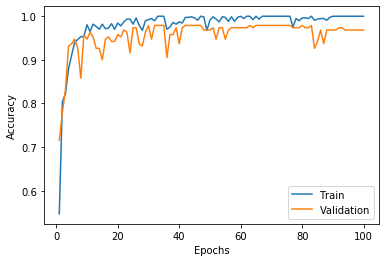

In [13]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_acc_history) + 1), average_acc_history)
plt.plot(range(1, len(average_val_acc_history) + 1), average_val_acc_history)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.savefig('stars_acc1.jpg')
plt.show()

The training accuracy converges quickly. We can afford to reduce the size of the model without having to lose any prediction power.

Let's remove a few hidden levels and perfrom 5-fold validation again.

In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

def build_model():
    model = Sequential()
    model.add(Dense(128, activation = 'relu', 
                    input_dim = X_train.shape[1]))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(6, activation = 'softmax'))

    model.compile(loss = 'categorical_crossentropy', 
                  optimizer = 'adam', 
                  metrics = ['acc'])
    return model

In [15]:
import numpy as np

k = 5
num_val_samples = len(X_train) // k
num_epochs = 100

all_loss_histories = []
all_val_loss_histories = []
all_acc_histories = []
all_val_acc_histories = []

for i in range(k):
    print('Processing Fold #', i + 1)
    
    val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = Y_train[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [X_train[:i * num_val_samples],
         X_train[(i + 1) * num_val_samples:]],
        axis = 0)
    partial_train_targets = np.concatenate(
        [Y_train[:i * num_val_samples],
         Y_train[(i + 1) * num_val_samples:]],
        axis = 0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        epochs = num_epochs, 
                        batch_size = 1, 
                        verbose = 0,
                        validation_data=(val_data, val_targets))
    
    loss_history = history.history['loss']
    all_loss_histories.append(loss_history)
    val_loss_history = history.history['val_loss']
    all_val_loss_histories.append(val_loss_history)
    
    acc_history = history.history['acc']
    all_acc_histories.append(acc_history)
    val_acc_history = history.history['val_acc']
    all_val_acc_histories.append(val_acc_history)

Processing Fold # 1
Processing Fold # 2
Processing Fold # 3
Processing Fold # 4
Processing Fold # 5


In [16]:
average_loss_history = [
    np.mean([x[i] for x in all_loss_histories]) for i in range(100)]

average_val_loss_history = [
    np.mean([x[i] for x in all_val_loss_histories]) for i in range(100)]

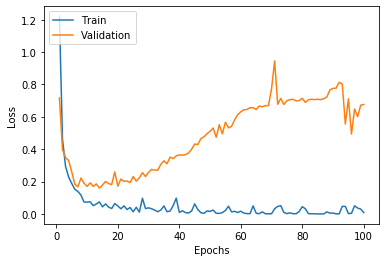

In [17]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_loss_history) + 1), average_loss_history)
plt.plot(range(1, len(average_val_loss_history) + 1), average_val_loss_history)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.savefig('stars_loss2.jpg')
plt.show()

It's definitely an improvement, but we can do better. Let's check the accuracy before we decide how to proceed.

In [18]:
average_acc_history = [
    np.mean([x[i] for x in all_acc_histories]) for i in range(100)]

average_val_acc_history = [
    np.mean([x[i] for x in all_val_acc_histories]) for i in range(100)]

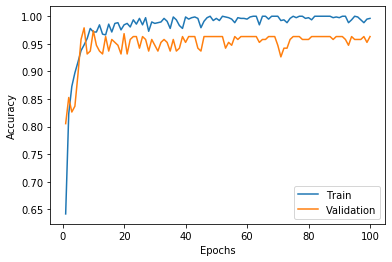

In [19]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_acc_history) + 1), average_acc_history)
plt.plot(range(1, len(average_val_acc_history) + 1), average_val_acc_history)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.savefig('stars_acc2.jpg')
plt.show()

We still have plenty of prediction power. Let's reduce the size of the layers again.

In [20]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

def build_model():
    model = Sequential()
    model.add(Dense(64, activation = 'relu', 
                    input_dim = X_train.shape[1]))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dense(6, activation = 'softmax'))

    model.compile(loss = 'categorical_crossentropy', 
                  optimizer = 'adam', 
                  metrics = ['acc'])
    return model

In [21]:
import numpy as np

k = 5
num_val_samples = len(X_train) // k
num_epochs = 100

all_loss_histories = []
all_val_loss_histories = []
all_acc_histories = []
all_val_acc_histories = []

for i in range(k):
    print('Processing Fold #', i + 1)
    
    val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = Y_train[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [X_train[:i * num_val_samples],
         X_train[(i + 1) * num_val_samples:]],
        axis = 0)
    partial_train_targets = np.concatenate(
        [Y_train[:i * num_val_samples],
         Y_train[(i + 1) * num_val_samples:]],
        axis = 0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        epochs = num_epochs, 
                        batch_size = 1, 
                        verbose = 0,
                        validation_data=(val_data, val_targets))
    
    loss_history = history.history['loss']
    all_loss_histories.append(loss_history)
    val_loss_history = history.history['val_loss']
    all_val_loss_histories.append(val_loss_history)
    
    acc_history = history.history['acc']
    all_acc_histories.append(acc_history)
    val_acc_history = history.history['val_acc']
    all_val_acc_histories.append(val_acc_history)

Processing Fold # 1
Processing Fold # 2
Processing Fold # 3
Processing Fold # 4
Processing Fold # 5


In [22]:
average_loss_history = [
    np.mean([x[i] for x in all_loss_histories]) for i in range(100)]

average_val_loss_history = [
    np.mean([x[i] for x in all_val_loss_histories]) for i in range(100)]

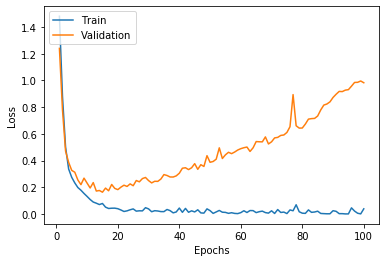

In [23]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_loss_history) + 1), average_loss_history)
plt.plot(range(1, len(average_val_loss_history) + 1), average_val_loss_history)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.savefig('stars_loss3.jpg')
plt.show()

In [24]:
average_acc_history = [
    np.mean([x[i] for x in all_acc_histories]) for i in range(100)]

average_val_acc_history = [
    np.mean([x[i] for x in all_val_acc_histories]) for i in range(100)]

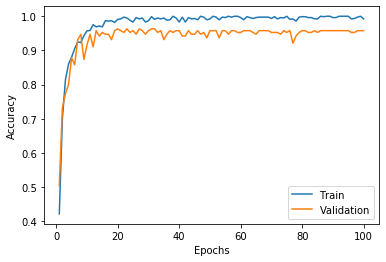

In [25]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_acc_history) + 1), average_acc_history)
plt.plot(range(1, len(average_val_acc_history) + 1), average_val_acc_history)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.savefig('stars_acc3.jpg')
plt.show()

In [26]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Dropout

def build_model():
    model = Sequential()
    model.add(Dense(64, activation = 'relu', 
                    input_dim = X_train.shape[1]))
    model.add(Dropout(.2))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(.2))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dropout(.2))
    model.add(Dense(6, activation = 'softmax'))

    model.compile(loss = 'categorical_crossentropy', 
                  optimizer = 'adam', 
                  metrics = ['acc'])
    return model

In [27]:
import numpy as np

k = 5
num_val_samples = len(X_train) // k
num_epochs = 100

all_loss_histories = []
all_val_loss_histories = []
all_acc_histories = []
all_val_acc_histories = []

for i in range(k):
    print('Processing Fold #', i + 1)
    
    val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = Y_train[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [X_train[:i * num_val_samples],
         X_train[(i + 1) * num_val_samples:]],
        axis = 0)
    partial_train_targets = np.concatenate(
        [Y_train[:i * num_val_samples],
         Y_train[(i + 1) * num_val_samples:]],
        axis = 0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        epochs = num_epochs, 
                        batch_size = 1, 
                        verbose = 0,
                        validation_data=(val_data, val_targets))
    
    loss_history = history.history['loss']
    all_loss_histories.append(loss_history)
    val_loss_history = history.history['val_loss']
    all_val_loss_histories.append(val_loss_history)
    
    acc_history = history.history['acc']
    all_acc_histories.append(acc_history)
    val_acc_history = history.history['val_acc']
    all_val_acc_histories.append(val_acc_history)

Processing Fold # 1
Processing Fold # 2
Processing Fold # 3
Processing Fold # 4
Processing Fold # 5


In [28]:
average_loss_history = [
    np.mean([x[i] for x in all_loss_histories]) for i in range(100)]

average_val_loss_history = [
    np.mean([x[i] for x in all_val_loss_histories]) for i in range(100)]

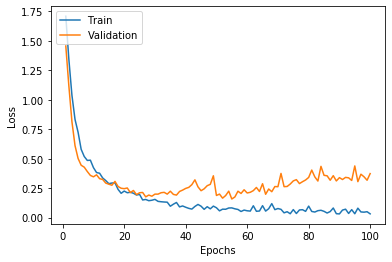

In [29]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_loss_history) + 1), average_loss_history)
plt.plot(range(1, len(average_val_loss_history) + 1), average_val_loss_history)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.savefig('stars_loss4.jpg')
plt.show()

In [30]:
average_acc_history = [
    np.mean([x[i] for x in all_acc_histories]) for i in range(100)]

average_val_acc_history = [
    np.mean([x[i] for x in all_val_acc_histories]) for i in range(100)]

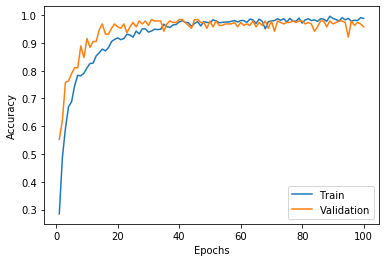

In [31]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_acc_history) + 1), average_acc_history)
plt.plot(range(1, len(average_val_acc_history) + 1), average_val_acc_history)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.savefig('stars_acc4.jpg')
plt.show()

In [32]:
model = build_model()

history = model.fit(X_train, Y_train, 
                    epochs = 40, 
                    batch_size = 1)

Epoch 1/40
192/192 [==============================] - 1s 7ms/step - loss: 1.6636 - acc: 0.3698
Epoch 2/40
192/192 [==============================] - 0s 2ms/step - loss: 1.1419 - acc: 0.5885
Epoch 3/40
192/192 [==============================] - 0s 2ms/step - loss: 0.9428 - acc: 0.6354
Epoch 4/40
192/192 [==============================] - 0s 2ms/step - loss: 0.7171 - acc: 0.6927
Epoch 5/40
192/192 [==============================] - 0s 2ms/step - loss: 0.5740 - acc: 0.7448
Epoch 6/40
192/192 [==============================] - 0s 2ms/step - loss: 0.5100 - acc: 0.7708
Epoch 7/40
192/192 [==============================] - 0s 2ms/step - loss: 0.4882 - acc: 0.7760
Epoch 8/40
192/192 [==============================] - 0s 2ms/step - loss: 0.4530 - acc: 0.7708
Epoch 9/40
192/192 [==============================] - 0s 2ms/step - loss: 0.4089 - acc: 0.8229
Epoch 10/40
192/192 [==============================] - 0s 2ms/step - loss: 0.4416 - acc: 0.7969
Epoch 11/40
192/192 [============================

In [33]:
loss, acc = model.evaluate(X_test, Y_test)
print('The accuracy for this model is: ', round(acc, 3))

48/48 [==============================] - 0s 7ms/step
The accuracy for this model is:  1.0
